In [5]:
import numpy as np
import h5py, json, os
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

## Some parameters (tweak as you like)

In [2]:
graph_verbosity = True    # If set to true, graphs will be plotted

f0 = 60e9       	# radar operating frequency
c = 3e8             # speed of light
wavelength = c/f0   # radar wavelength

Rmin = 0.2          # min distance
Rmax = 0.8          # max distance

Tt = 30             # Np/Fs, total time taken for measurement
Fs = 2*f0/1e6       # sampling frequency

rangeList = np.arange(int(Rmin*100), int(Rmax*100)+1, 10)   # Distance range (do not change)

## Read the h5 file
`radarData` contains a `complex128` dtype array with dimensions (Nframe, NTS).

In [7]:
def parse_h5(file_path):
    hf = h5py.File(os.path.join('gestures_22_sep', file_path), 'r')
    radarData = np.squeeze(np.array(hf['/data']))
    hf.close()
    return radarData

radarDataS = [parse_h5(path) for path in os.listdir('gestures_22_sep') if path.endswith('.h5')]

Nframe, NTS = radarDataS[0].shape
radarDataS[0].shape

(128, 1240)

## Magnitude Plot / Output Signal Profile
The magnitude of the signal can found using `np.abs(radarData).T`, the tranpose function is to align the time axis correctly.

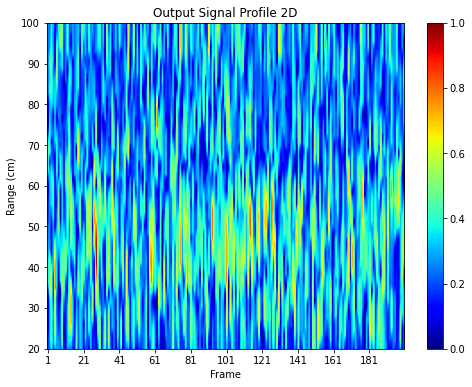

In [7]:
fig, axes = plt.subplots(10, 3, figsize=(100, 30))

for i in range(3):
    for j in range(10):

        magnitudeData = np.abs(radarDataS).T
        normalizedMagnitudeData = magnitudeData / np.max(magnitudeData)

        # Predefine x and y ticks beforehand
        xticks = np.arange(0, Nframe, Nframe//10)
        yticks = np.linspace(0, NTS-1, rangeList.shape[0])

        plt.figure(figsize=(8, 6))
        plt.imshow(normalizedMagnitudeData, aspect='auto', origin='lower', cmap='jet');
        plt.colorbar();
        plt.title('Output Signal Profile 2D');
        plt.xlabel('Frame'); plt.ylabel('Range (cm)');
        plt.xticks(ticks=xticks, labels=xticks+1);
        plt.yticks(ticks=yticks, labels=rangeList);

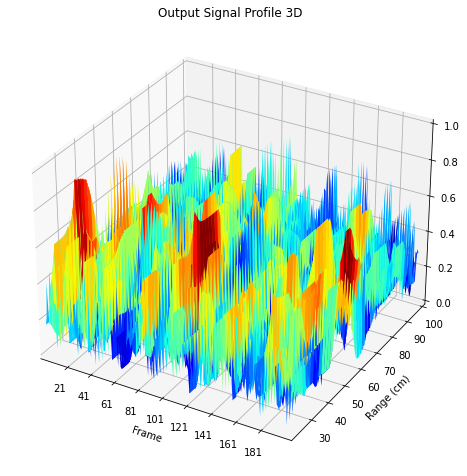

In [8]:
# if graph_verbosity:
#     plt.figure(figsize=(8, 10));
#     ax = plt.axes(projection='3d');
#     xx, yy = np.meshgrid(np.arange(Nframe), np.arange(NTS));
#     ax.contour3D(xx, yy, normalizedMagnitudeData, 200, cmap='jet');
#     ax.invert_xaxis();

if graph_verbosity:
    fig = plt.figure(figsize=(8, 10));
    ax = plt.axes(projection='3d');
    xx, yy = np.meshgrid(np.arange(Nframe), np.arange(NTS));
    ax.plot_surface(xx, yy, normalizedMagnitudeData, cmap='jet');
    ax.set_xticks(xticks); ax.set_xticklabels(xticks+1); ax.set_xlim((1, Nframe));
    ax.set_yticks(yticks); ax.set_yticklabels(rangeList); ax.set_ylim((1, NTS));
    ax.set_title('Output Signal Profile 3D');
    ax.set_xlabel('Frame'); ax.set_ylabel('Range (cm)');

## Time Domain Response
Unwrap the `radarData` array to a 1D time series. Normalize by subtracting the mean and scaling to 0-1.

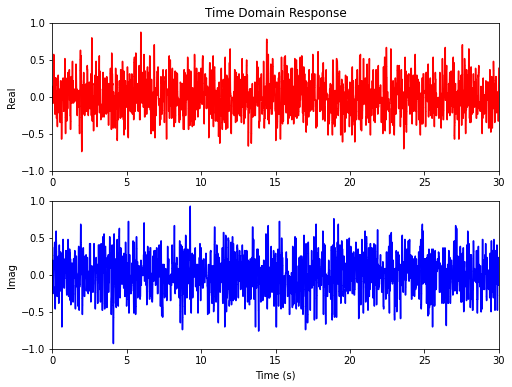

In [9]:
# Number of data points
Np = NTS * Nframe

# Unwrap and normalize data
radar1D = radarData.reshape(Np, 1).squeeze()
radar1D = radar1D - radar1D.mean()
radar1DNormalised = radar1D / np.max(np.abs(radar1D))

# Some plotting parameters
timeAxis = np.linspace(0, Tt, Np)

if graph_verbosity:
    fig, ax = plt.subplots(2, 1, figsize=(8, 6));
    ax[0].plot(timeAxis, np.real(radar1DNormalised), 'red');
    ax[0].set_xlim((0, Tt)); ax[0].set_ylim((-1, 1));
    ax[0].set_ylabel('Real');
    ax[0].set_title('Time Domain Response');
    ax[1].plot(timeAxis, np.imag(radar1DNormalised), 'blue');
    ax[1].set_xlim((0, Tt)); ax[1].set_ylim((-1, 1));
    ax[1].set_ylabel('Imag');
    ax[1].set_xlabel('Time (s)');
    plt.show();

## Frequency Domain Response
Find frequency response via `np.fft.fft`, save in `radar1DFreq`.  
Normalise data and plot the power spectrum.

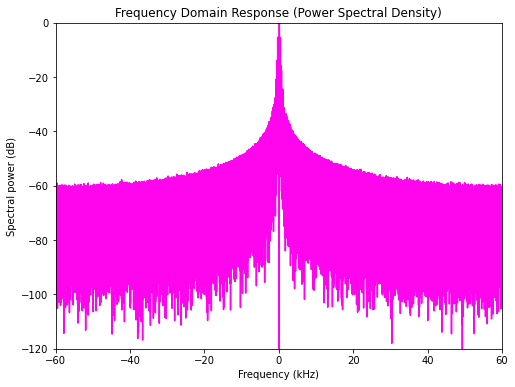

In [10]:
# FFT (center is 0 Doppler frequency) and convert to power spectrum
radar1DFreq = np.fft.fftshift(np.fft.fft(radar1D))
radar1DFreqDB = 20 * np.log10(np.abs(radar1DFreq))

# Normalize data (maximum value is 0 dB)
radar1DFreqDBNormalized = radar1DFreqDB - np.max(radar1DFreqDB)

# Some plotting parameters
freqAxis = np.linspace(-Fs/2, Fs/2, Np)

if graph_verbosity:
    plt.figure(figsize=(8, 6))
    plt.plot(freqAxis/1e3, radar1DFreqDBNormalized, '#ff05ee');
    plt.title('Frequency Domain Response (Power Spectral Density)')
    plt.xlabel('Frequency (kHz)'); plt.xlim((-60, 60));
    plt.ylabel('Spectral power (dB)'); plt.ylim((-120, 0));
    plt.show();

## Doppler-Time Response (STFT)
*This part is hard ... >.<*

References (click for link):
- Python SciPy Module:&nbsp;&nbsp;[`scipy.signal.get_window`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html),&nbsp;&nbsp;[`scipy.signal.windows.taylor`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.taylor.html),&nbsp;&nbsp;[`scipy.signal.spectrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html)
- MATLAB Signal Processing Toolbox:&nbsp;&nbsp;[`taylorwin`](https://www.mathworks.com/help/signal/ref/taylorwin.html),&nbsp;&nbsp;[`spectrogram`](https://www.mathworks.com/help/signal/ref/spectrogram.html)

C:\Users\Philip\AppData\Roaming\Python\Python37\site-packages\scipy\signal\spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


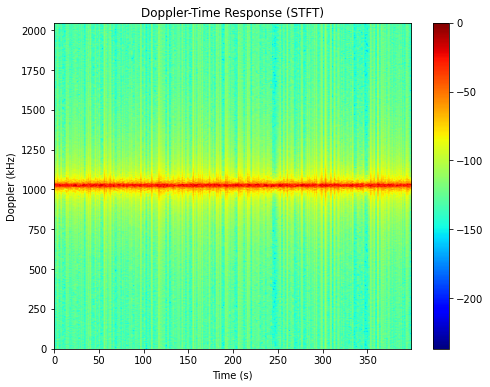

In [11]:
# Some parameters to tweak
overlapPercent = 0.8                                     # Percentage of data overlapping STFT
NFFT = 1024 * 2   	                                     # FFT point numbers: 2^10=1024 2^12=4096 2^13=8192

# Resolution parameters
timeSegment = NFFT / Fs                                  # Time for each time segment in FFT processing
dResolution = 1 / timeSegment                            # Doppler resolution (Hz)
tResolution = (NFFT*(1-overlapPercent)) * 1/Fs           # Time resolution (s)
vResolution = dResolution * wavelength / 2               # Velocity resolution (m/s)

# Doppler window for FFT sidelobe suppression and STFT
NOverlap = round(NFFT*overlapPercent);                   # Number of overlapping points
window = signal.windows.taylor(NFFT, nbar=10, sll=80, norm=False)
dAxis, tAxis, STFT = signal.spectrogram(radar1D, axis=0, fs=Fs, window=window, noverlap=NOverlap, nfft=NFFT)     

# Frequency shifting and representation of magnitude in dB
STFTShift = np.fft.fftshift(STFT, axes=0)                # fftshift means 0 Doppler frequency is at center
dAxis = dAxis - Fs/2;                                    # Shift center as 0 Doppler frequency
STFTShiftDB = 20 * np.log10(np.abs(STFTShift))           # Represent in dB
STFTShiftDB = STFTShiftDB - np.max(STFTShiftDB)          # Normalize data to max value (i.e., the max value is 0dB)

# Show the STFT signature
plt.figure(figsize=(8, 6));
plt.imshow(STFTShiftDB, aspect='auto', origin='lower', cmap='jet');
plt.colorbar();
plt.title('Doppler-Time Response (STFT)');
plt.xlabel('Time (s)'); plt.ylabel('Doppler (kHz)');
plt.show();

In [12]:
radar1D

array([-4.49493349+10.35989722j, -4.49493349+10.35989722j,
       -4.49493349+10.35989722j, ..., 20.50506651+11.35989722j,
       20.50506651+11.35989722j, 20.50506651+11.35989722j])